##### Preprocessing:

- **Filtering**: Apply appropriate filters to remove noise and artifacts from the EEG signals. Common filters include bandpass, highpass, and notch filters.
- **Artifact Removal**: Use techniques such as Independent Component Analysis (ICA) or template matching to identify and remove artifacts such as eye blinks or muscle activity.
- **Resampling**: If needed, resample the EEG data to a lower or higher sampling rate to match the requirements of your analysis.
- **Baseline Correction**: Optionally, apply baseline correction to remove baseline drifts or shifts in the EEG signals.

##### Feature Extraction:

- **Time-Domain Features**: Compute statistical features such as mean, variance, skewness, and kurtosis for each EEG channel.
- **Frequency-Domain Features**: Compute power spectral density (PSD) using techniques like Fast Fourier Transform (FFT) or wavelet analysis.
- **Spatial Features**: Compute spatial features such as coherence or phase synchronization between EEG channels.
- **Event-Related Potentials (ERPs)**: If applicable, extract ERPs related to specific events or stimuli from the EEG data.

In [10]:
import os
import re
from collections import defaultdict
from typing import List, Tuple, Dict
from mne.io import read_raw, Raw, read_raw_fif 
import mne

from mne.annotations import Annotations
from mne.epochs import Epochs
from mne.preprocessing import ICA, read_ica, find_bad_channels_lof, create_eog_epochs
from mne import concatenate_raws, events_from_annotations, Epochs, Annotations
import copy
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyprep.find_noisy_channels import NoisyChannels

from save_and_load import load_eeg_data

In [11]:
baseInputPath = './Data/Offline EEG data'
# baseOutputPath = './Data/proceesed EEG data'
subjects = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10']
attempted_movement_runs = ['Run 3', 'Run 4', 'Run 5', 'Run 6', 'Run 7', 'Run 10', 'Run 11', 'Run 12', 'Run 13']
participant_runs = defaultdict(list)

for subject in subjects:
    for run in attempted_movement_runs:
        file_path = f'{baseInputPath}/{subject}/{subject} {run}.gdf'

        try:
            rawEEG = read_raw(file_path, preload=True)
            rawEEG.set_channel_types({'eog-l': 'eog', 'eog-m': 'eog', 'eog-r': 'eog'})
            participant_runs[subject].append(rawEEG)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Convert defaultdict to regular dictionary
eeg_raw_dict = dict(participant_runs)


Extracting EDF parameters from /Users/diegosabajo/Documents/Projects/A.I./Prototype/EEG_Analysis/Data/Offline EEG data/P01/P01 Run 3.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
AFz, F3, F1, Fz, F2, F4, FFC5h, FFC3h, FFC1h, FFC2h, FFC4h, FFC6h, FC5, FC3, FC1, FCz, FC2, FC4, FC6, FCC5h, FCC3h, FCC1h, FCC2h, FCC4h, FCC6h, C5, C3, C1, Cz, C2, C4, C6, CCP5h, CCP3h, CCP1h, CCP2h, CCP4h, CCP6h, CP5, CP3, CP1, CPz, CP2, CP4, CP6, CPP5h, CPP3h, CPP1h, CPP2h, CPP4h, CPP6h, P5, P3, P1, Pz, P2, P4, P6, PPO1h, PPO2h, POz, eog-l, eog-m, eog-r
Creating raw.info structure...
Reading 0 ... 75519  =      0.000 ...   294.996 secs...
Extracting EDF parameters from /Users/diegosabajo/Documents/Projects/A.I./Prototype/EEG_Analysis/Data/Offline EEG data/P01/P01 Run 4.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
A

In [12]:
def get_raw_eeg(eeg_dict: dict[List], participant_id: str)-> List:
  participant_runs = eeg_dict.get(participant_id, [])
  return participant_runs

### 1. Exploratory Data Analysis (EDA)

In [13]:
participant_01_runs = get_raw_eeg(eeg_raw_dict, 'P01')

In [14]:
print(participant_01_runs[0].info['ch_names'])
participant_01_runs[0].info

['AFz', 'F3', 'F1', 'Fz', 'F2', 'F4', 'FFC5h', 'FFC3h', 'FFC1h', 'FFC2h', 'FFC4h', 'FFC6h', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'CPP5h', 'CPP3h', 'CPP1h', 'CPP2h', 'CPP4h', 'CPP6h', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PPO1h', 'PPO2h', 'POz', 'eog-l', 'eog-m', 'eog-r']


Measurement date,"April 04, 2017 13:04:15 GMT"
Experimenter,Unknown
Participant,mit
Digitized points,Not available
Good channels,"61 EEG, 3 EOG"
Bad channels,None
EOG channels,"eog-l, eog-m, eog-r"
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


In [15]:
participant_01_runs[0].del_proj()

Measurement date,"April 04, 2017 13:04:15 GMT"
Experimenter,Unknown
Participant,mit
Digitized points,Not available
Good channels,"61 EEG, 3 EOG"
Bad channels,None
EOG channels,"eog-l, eog-m, eog-r"
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


Effective window size : 8.000 (s)


Plotting power spectral density (dB=True).
ax Axes(0.125,0.11;0.775x0.77)


/Users/diegosabajo/miniconda3/envs/neural_ml/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


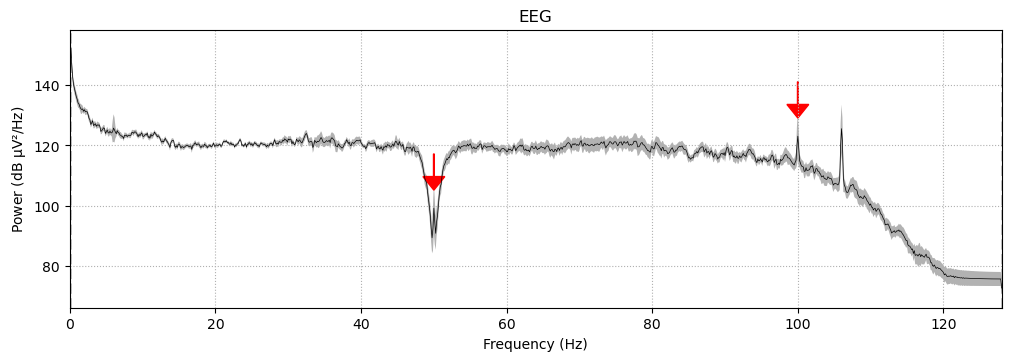

In [16]:
fig = participant_01_runs[0].compute_psd(tmax=np.inf, fmax=128).plot(average=True, amplitude=False,
                                                      picks='data', exclude='bads')
for ax in fig.axes:
  print('ax', ax)
  freqs = ax.lines[-1].get_xdata()
  psds = ax.lines[-1].get_ydata()
  for freq in (50, 100):
    idx = np.searchsorted(freqs, freq)
    ax.arrow(
      x = freqs[idx],
      y = psds[idx] + 18,
      dx = 0,
      dy = -12, 
      color = 'red',
      width = 0.1,
      head_width = 3,
      length_includes_head = True,
    )
plt.show()

In [17]:
def print_time(eegDataDict: dict[List]):
    total_time = []
    for participant_id, eegData in eegDataDict.items():
        print(f"Participant {participant_id}:")
        for i, rawEEG in enumerate(eegData):
            time = rawEEG.get_data().shape[1] / rawEEG.info['sfreq']
            total_time.append(time)
            print(f'  Run {i + 1} - Time(s):', time)
    print('Total time(h):', sum(total_time) / 3600)

print_time(eeg_raw_dict)

Participant P01:
  Run 1 - Time(s): 295.0
  Run 2 - Time(s): 299.0
  Run 3 - Time(s): 300.0
  Run 4 - Time(s): 297.0
  Run 5 - Time(s): 301.0
  Run 6 - Time(s): 304.0
  Run 7 - Time(s): 301.0
  Run 8 - Time(s): 304.0
  Run 9 - Time(s): 302.0
Participant P02:
  Run 1 - Time(s): 301.0
  Run 2 - Time(s): 304.0
  Run 3 - Time(s): 301.0
  Run 4 - Time(s): 304.0
  Run 5 - Time(s): 302.0
  Run 6 - Time(s): 308.0
  Run 7 - Time(s): 301.0
  Run 8 - Time(s): 302.0
  Run 9 - Time(s): 301.0
Participant P03:
  Run 1 - Time(s): 299.0
  Run 2 - Time(s): 300.0
  Run 3 - Time(s): 297.0
  Run 4 - Time(s): 301.0
  Run 5 - Time(s): 304.0
  Run 6 - Time(s): 301.0
  Run 7 - Time(s): 304.0
  Run 8 - Time(s): 302.0
  Run 9 - Time(s): 308.0
Participant P04:
  Run 1 - Time(s): 299.0
  Run 2 - Time(s): 300.0
  Run 3 - Time(s): 297.0
  Run 4 - Time(s): 301.0
  Run 5 - Time(s): 304.0
  Run 6 - Time(s): 304.0
  Run 7 - Time(s): 302.0
  Run 8 - Time(s): 308.0
  Run 9 - Time(s): 301.0
Participant P05:
  Run 1 - Time(

In [18]:
participant_01_runs[0].plot(title='Raw EEG Data', block=False, scalings='50.0', color='black',
          )
plt.show()

2024-06-15 20:00:33,919 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.1a1


In [19]:
import os
import numpy as np

def print_missing_values_per_run(rawEEGDict):
    for participant_id, rawEEGList in rawEEGDict.items():
        print(f"Participant {participant_id}:")
        for i, rawEEG in enumerate(rawEEGList):
            filename = os.path.basename(rawEEG.filenames[0])
            total_missing_values = np.isnan(rawEEG.get_data()).sum()
            shape = rawEEG.get_data().shape
            total_missing_values_per_channel = total_missing_values / shape[0]
            print(f'  Run {i + 1} - Filename: {filename}')
            print('    Total Missing Values:', total_missing_values)
            print('    Shape of data:', shape)
            print('    Total Missing Values per channel:', total_missing_values_per_channel)
            print('=========================')

print_missing_values_per_run(eeg_raw_dict)

Participant P01:
  Run 1 - Filename: P01 Run 3.gdf
    Total Missing Values: 704
    Shape of data: (64, 75520)
    Total Missing Values per channel: 11.0
  Run 2 - Filename: P01 Run 4.gdf
    Total Missing Values: 5440
    Shape of data: (64, 76544)
    Total Missing Values per channel: 85.0
  Run 3 - Filename: P01 Run 5.gdf
    Total Missing Values: 4416
    Shape of data: (64, 76800)
    Total Missing Values per channel: 69.0
  Run 4 - Filename: P01 Run 6.gdf
    Total Missing Values: 12928
    Shape of data: (64, 76032)
    Total Missing Values per channel: 202.0
  Run 5 - Filename: P01 Run 7.gdf
    Total Missing Values: 3008
    Shape of data: (64, 77056)
    Total Missing Values per channel: 47.0
  Run 6 - Filename: P01 Run 10.gdf
    Total Missing Values: 2304
    Shape of data: (64, 77824)
    Total Missing Values per channel: 36.0
  Run 7 - Filename: P01 Run 11.gdf
    Total Missing Values: 9664
    Shape of data: (64, 77056)
    Total Missing Values per channel: 151.0
  Run 

In [20]:
def print_missing_values_array(rawEEGDict):
    for participant_id, rawEEGList in rawEEGDict.items():
        print(f"Participant {participant_id}:")
        for rawEEG in rawEEGList:
            filename = os.path.basename(rawEEG.filenames[0])
            nan_indices = np.where(np.isnan(rawEEG.get_data()[60]))
            print(f'  Filename: {filename}')
            print('  Indices of missing values:', nan_indices)
            print('  =========================')

print_missing_values_array(eeg_raw_dict)

Participant P01:
  Filename: P01 Run 3.gdf
  Indices of missing values: (array([75509, 75510, 75511, 75512, 75513, 75514, 75515, 75516, 75517,
       75518, 75519]),)
  Filename: P01 Run 4.gdf
  Indices of missing values: (array([76459, 76460, 76461, 76462, 76463, 76464, 76465, 76466, 76467,
       76468, 76469, 76470, 76471, 76472, 76473, 76474, 76475, 76476,
       76477, 76478, 76479, 76480, 76481, 76482, 76483, 76484, 76485,
       76486, 76487, 76488, 76489, 76490, 76491, 76492, 76493, 76494,
       76495, 76496, 76497, 76498, 76499, 76500, 76501, 76502, 76503,
       76504, 76505, 76506, 76507, 76508, 76509, 76510, 76511, 76512,
       76513, 76514, 76515, 76516, 76517, 76518, 76519, 76520, 76521,
       76522, 76523, 76524, 76525, 76526, 76527, 76528, 76529, 76530,
       76531, 76532, 76533, 76534, 76535, 76536, 76537, 76538, 76539,
       76540, 76541, 76542, 76543]),)
  Filename: P01 Run 5.gdf
  Indices of missing values: (array([76731, 76732, 76733, 76734, 76735, 76736, 7673

- It appears that all the missing values are continuous
- It also appears that the missing values are at the end of the recording (looking at data shape and missing values)

In [21]:
def print_missing_time_values(eegDataDict: dict[List], n: int):
    """Prints an array of missing time values.

    Args:
        eegDataDict (dict): Dictionary of EEG data from participants and runs.
        n (int): Index of the channel to check for missing time values.
    """
    for participant_id, rawEEGList in eegDataDict.items():
        print(f"Participant {participant_id}:")
        for i, rawEEG in enumerate(rawEEGList):
            filename = os.path.basename(rawEEG.filenames[0])
            nan_indices_channel_n = np.where(np.isnan(rawEEG.get_data())[n])
            recording_duration = rawEEG.get_data().shape[1] / rawEEG.info['sfreq']
            missing_time = nan_indices_channel_n[0]/ rawEEG.info['sfreq']
            print(f'  {i + 1} Filename: {filename}')
            print('  Recording Duration (s):', recording_duration)
            print('  Missing Time(s):', missing_time)
            print('  =========================')

print_missing_time_values(eeg_raw_dict, 1)


Participant P01:
  1 Filename: P01 Run 3.gdf
  Recording Duration (s): 295.0
  Missing Time(s): [294.95703125 294.9609375  294.96484375 294.96875    294.97265625
 294.9765625  294.98046875 294.984375   294.98828125 294.9921875
 294.99609375]
  2 Filename: P01 Run 4.gdf
  Recording Duration (s): 299.0
  Missing Time(s): [298.66796875 298.671875   298.67578125 298.6796875  298.68359375
 298.6875     298.69140625 298.6953125  298.69921875 298.703125
 298.70703125 298.7109375  298.71484375 298.71875    298.72265625
 298.7265625  298.73046875 298.734375   298.73828125 298.7421875
 298.74609375 298.75       298.75390625 298.7578125  298.76171875
 298.765625   298.76953125 298.7734375  298.77734375 298.78125
 298.78515625 298.7890625  298.79296875 298.796875   298.80078125
 298.8046875  298.80859375 298.8125     298.81640625 298.8203125
 298.82421875 298.828125   298.83203125 298.8359375  298.83984375
 298.84375    298.84765625 298.8515625  298.85546875 298.859375
 298.86328125 298.8671875  2

- All of the missing values are around 1 second or less 
- This could be because the recording went on before stopping.

In [ ]:
print('Total Missing Values:', sum(np.isnan(participant_01_runs[0].get_data())))

Total Missing Values: [ 0  0  0 ... 64 64 64]


Channels marked as bad:
none


In [ ]:
missing_value_array = sum(np.isnan(participant_01_runs[0].get_data()))
print(missing_value_array)
print(len(missing_value_array))
print(np.sum(missing_value_array))
print(np.where(missing_value_array))

[ 0  0  0 ... 64 64 64]
75520
704
(array([75509, 75510, 75511, 75512, 75513, 75514, 75515, 75516, 75517,
       75518, 75519]),)


In [ ]:
nan_values = np.where(np.isnan(participant_01_runs[0].get_data()))

channel_indices = nan_values[0]
time_point_indices = nan_values[1]

missing_times = np.round(time_point_indices / rawEEG.info['sfreq'], 3)

print("Indices of NaN values along channels:", channel_indices)
print("Indices of NaN values along time points:", time_point_indices)

print(len(channel_indices))
print(len(time_point_indices))

print(missing_times, len(missing_times))
print(np.min(missing_times))

Indices of NaN values along channels: [ 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  2  2
  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10
 10 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 13
 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 15 15 15
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17
 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19
 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21
 21 21 22 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 25 26 26
 26 26 26 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28
 28 28 28 28 

In [ ]:
def crop_eeg_data(eegDataDict: dict[List]) -> dict[List]:
    """
    Crops the EEG data to the earliest time point with missing values.

    Args:
        eegDataDict (dict): Dictionary of EEG data from participants and runs.
    Returns:
        dict: Dictionary of cropped EEG data with NaN values removed.
    """
    cropped_eeg_data = {}
    earliest_missing_time = float('inf')
    
    for participant_id, rawEEGList in eegDataDict.items():
        cropped_eeg_data[participant_id] = []

        for i, rawEEG in enumerate(rawEEGList):
            data = rawEEG.get_data()
            sfreq = rawEEG.info['sfreq']

            nan_indices = np.where(np.isnan(data))
            missing_times = nan_indices[1] / sfreq
            new_earliest_time = np.min(missing_times)
            new_earliest_time = np.floor(new_earliest_time * 100) / 100

            if new_earliest_time < earliest_missing_time:
                earliest_missing_time = new_earliest_time

            cropped_rawEEG = rawEEG.copy().crop(tmin=0, tmax=earliest_missing_time)
            print(f'{participant_id}, Run {i + 1} - Total Missing Values:', sum(sum(np.isnan(cropped_rawEEG.get_data()))))
            cropped_eeg_data[participant_id].append(cropped_rawEEG)

    return cropped_eeg_data

cropped_eeg_data_dict = crop_eeg_data(eeg_raw_dict)

P01, Run 1 - Total Missing Values: 0
P01, Run 2 - Total Missing Values: 0
P01, Run 3 - Total Missing Values: 0
P01, Run 4 - Total Missing Values: 0
P01, Run 5 - Total Missing Values: 0
P01, Run 6 - Total Missing Values: 0
P01, Run 7 - Total Missing Values: 0
P01, Run 8 - Total Missing Values: 0
P01, Run 9 - Total Missing Values: 0
P02, Run 1 - Total Missing Values: 0
P02, Run 2 - Total Missing Values: 0
P02, Run 3 - Total Missing Values: 0
P02, Run 4 - Total Missing Values: 0
P02, Run 5 - Total Missing Values: 0
P02, Run 6 - Total Missing Values: 0
P02, Run 7 - Total Missing Values: 0
P02, Run 8 - Total Missing Values: 0
P02, Run 9 - Total Missing Values: 0
P03, Run 1 - Total Missing Values: 0
P03, Run 2 - Total Missing Values: 0
P03, Run 3 - Total Missing Values: 0
P03, Run 4 - Total Missing Values: 0
P03, Run 5 - Total Missing Values: 0
P03, Run 6 - Total Missing Values: 0
P03, Run 7 - Total Missing Values: 0
P03, Run 8 - Total Missing Values: 0
P03, Run 9 - Total Missing Values: 0
P

#### 1.1 Detecting and Interpolating Bad Channels

In [ ]:
manual_bad_channel_eeg = copy.deepcopy(cropped_eeg_data_dict)

participant_01_runs = get_raw_eeg(manual_bad_channel_eeg, 'P01')
participant_02_runs = get_raw_eeg(manual_bad_channel_eeg, 'P02')
participant_03_runs = get_raw_eeg(manual_bad_channel_eeg, 'P03')
participant_04_runs = get_raw_eeg(manual_bad_channel_eeg, 'P04')
participant_05_runs = get_raw_eeg(manual_bad_channel_eeg, 'P05')
participant_06_runs = get_raw_eeg(manual_bad_channel_eeg, 'P06')
participant_07_runs = get_raw_eeg(manual_bad_channel_eeg, 'P07')
participant_08_runs = get_raw_eeg(manual_bad_channel_eeg, 'P08')
participant_09_runs = get_raw_eeg(manual_bad_channel_eeg, 'P09')
participant_10_runs = get_raw_eeg(manual_bad_channel_eeg, 'P10')


In [ ]:
participant_10_runs[0].plot(title='EEG Raw Without Missing Values', block=False, scalings='50.0',
            picks='all', color='black',
          )
plt.show()

Using pyopengl with version 3.1.1a1


#### 1.1.1 Filtering for Bad Channel Detection

In [ ]:
def filter_eeg_data(eegDataDict: dict[List], hp: int, lp=None) -> dict[List]:
    """
    Filters the EEG data using a high-pass and low-pass filter.

    Args:
        eegDataDict (dict): Dictionary of EEG data from participants and runs.
        hp (int): High-pass filter frequency (in Hz).
        lp (int): Low-pass filter frequency (in Hz), default is None.
    Returns:
        dict: Dictionary of filtered EEG data with high-pass and low-pass filters applied.
    """
    filtered_eeg_data = {}

    for participant_id, rawEEGList in eegDataDict.items():
        filtered_eeg_data[participant_id] = []

        for i, rawEEG in enumerate(rawEEGList):
            filtered_rawEEG = rawEEG.copy().filter(hp, lp)
            filtered_eeg_data[participant_id].append(filtered_rawEEG)

    return filtered_eeg_data

In [ ]:
filtered_eeg_data_dict = filter_eeg_data(cropped_eeg_data_dict, hp=0.1, lp=None)

#### 1.1.2 Automatic Bad Channel Selection

In [ ]:
class HandleBadChannels():
    def __init__(self, bad_chan_lof=find_bad_channels_lof, NC=NoisyChannels):
        """
        Initialize the HandleBadChannels class.
        Args:
            bad_chan_lof (function): Function to detect bad channels using LOF algorithm.
            NC (class): Class for detecting bad channels using the PREP pipeline.
        """
        self.bad_chan_lof = bad_chan_lof
        self.NC = NC

    def LOF_bads_suggestion(self, eeg_data: Dict[str, List[Raw]]) -> Dict[str, Tuple[List[List[str]], List[List[float]]]]:
        """
        Detects bad channels using the Local Outlier Factor (LOF) algorithm.

        Args:
            eeg_data (dict): A dictionary of participant IDs mapping to a list of MNE Raw objects.

        Returns:
            dict: A dictionary containing participant IDs as keys and tuples containing a list of bad channels and a list of LOF scores as values.
        """
        bad_channels = []
        lof_scores = []
        for subject_id, raws in eeg_data.items():
            for idx, raw in enumerate(raws):
                print(f'Run {idx + 1} for {subject_id}')
                try:
                    bad_chans, scores = self.bad_chan_lof(raw, picks=['eeg'], return_scores=True)
                    bad_channels.append(bad_chans)
                    lof_scores.append(scores)
                except Exception as e:
                    print(f"Error detecting bad channels for data {idx} of {subject_id}: {e}")
        return bad_channels, lof_scores

    def PREP_bads_suggestion(self, eeg_data: Dict[str, List[Raw]]) -> Dict[str, List[List[str]]]:
        """
        Apply the PREP pipeline to detect bad channels.
        Args:
            eeg_data (dict): A dictionary of participant IDs mapping to a list of MNE Raw objects.
        Returns:
            dict: A dictionary containing participant IDs as keys and lists of bad channels detected by the PREP pipeline as values.
        """
        bad_channels = []
        for subject_id, raws in eeg_data.items():
            for idx, raw in enumerate(raws):
                print(f'Run {idx + 1} for {subject_id}')
                try:
                    raw.set_montage('standard_1005')
                    raw.pick(picks=['eeg', 'eog'])
                    nc = self.NC(raw=raw, do_detrend=True)
                    nc.find_all_bads(channel_wise=True)
                    bad_channels.append(nc.get_bads())
                except Exception as e:
                    print(f"Error applying PREP pipeline for data {idx} of {subject_id}: {e}")
        return bad_channels
      
    def select_channels_as_bad(self, lof_chans: List[List[str]], pyprep_chans: List[List[str]]) -> List[List[str]]:
        """
        Select channels that are marked as bad in both LOF scores and PREP suggestions.
        Args:
            lof_chans (list): List of bad channels from the LOF algorithm.
            pyprep_chans (list): List of bad channels from the PREP pipeline.
        Returns:
            list: A list of unique bad channels.
        """
        unique_bad_channels = []
        for (lof_bad, pyprep_bad) in zip(lof_chans, pyprep_chans):
            try:
                unique_bad_chan = set(lof_bad) & set(pyprep_bad)
                unique_bad_channels.append(list(unique_bad_chan))
            except Exception as e:
                print(f"Error selecting bad channels: {e}")
        return unique_bad_channels

    def mark_bad_channels(self, eeg_data: Dict[str, List[Raw]], bad_channels: List[List[str]]) -> None:
        """
        Marks bad channels in the EEG data dictionary.
        Args:
            eeg_data (dict): A dictionary of participant IDs mapping to a list of MNE Raw objects.
            bad_channels (dict): A dictionary containing participant IDs as keys and lists of bad channels as values.
        Returns:
            None
        """
        for subject_id, raws in eeg_data.items():
            for i, raw in enumerate(raws):
                try:
                    raw.info['bads'].extend(bad_channels[i])
                except Exception as e:
                    print(f"Error marking bad channels for data {i} of {subject_id}: {e}")            

    def reconstruct_bad_channels(self, eeg_data: Dict[str, List[Raw]]) -> Dict[str, List[Raw]]:
        """
        Reconstructs bad channels in the EEG data dictionary by interpolating them.
        Args:
            eeg_data (dict): A dictionary of participant IDs mapping to a list of MNE Raw objects.
        Returns:
            dict: A dictionary containing participant IDs as keys and lists of MNE Raw objects after reconstructing bad channels.
        """
        for subject_id, raws in eeg_data.items():
            for idx, raw in enumerate(raws):
                try:
                    raw = raw.interpolate_bads(reset_bads=True, verbose=False)
                except Exception as e:
                    print(f"Error reconstructing bad channels for data {idx} of {subject_id}: {e}")
        return eeg_data

In [ ]:
HBC = HandleBadChannels()
# lof_bad_chans, lof_scores = HBC.LOF_bads_suggestion(cropped_eeg_data_dict)
pyprep_bad_chans = HBC.PREP_bads_suggestion(filtered_eeg_data_dict)
HBC.mark_bad_channels(filtered_eeg_data_dict, pyprep_bad_chans)

Run 1 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 55
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 56
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 57
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 57
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P01
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 55
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P02
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P03
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P04
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P05
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 56
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P06
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P07
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P08
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 56
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 56
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 57
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 56
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P09
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 1 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 2 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 3 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 60
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 4 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 5 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 6 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 7 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 8 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Run 9 for P10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!


In [ ]:
participant_01_runs = get_raw_eeg(filtered_eeg_data_dict, 'P01')
participant_02_runs = get_raw_eeg(filtered_eeg_data_dict, 'P02')
participant_03_runs = get_raw_eeg(filtered_eeg_data_dict, 'P03')
participant_04_runs = get_raw_eeg(filtered_eeg_data_dict, 'P04')
participant_05_runs = get_raw_eeg(filtered_eeg_data_dict, 'P05')
participant_06_runs = get_raw_eeg(filtered_eeg_data_dict, 'P06')
participant_07_runs = get_raw_eeg(filtered_eeg_data_dict, 'P07')
participant_08_runs = get_raw_eeg(filtered_eeg_data_dict, 'P08')
participant_09_runs = get_raw_eeg(filtered_eeg_data_dict, 'P09')
participant_10_runs = get_raw_eeg(filtered_eeg_data_dict, 'P10')

In [ ]:
participant_01_runs[0].plot(title='EEG Raw Without Missing Values', block=False, scalings='50.0',
            picks='all', color='black',
          )
plt.show()

Using pyopengl with version 3.1.1a1


Channels marked as bad:
['C1', 'FCC4h']


In [ ]:
def print_bad_channels(eeg_raw_data: dict[List[Raw]]) -> None:
  for participant_id, rawEEGList in eeg_raw_data.items():
    print(f"Participant {participant_id}:")
    for i, rawEEG in enumerate(rawEEGList):
      print(f'  Run {i + 1} - Bad Channels:', rawEEG.info['bads'])
      
print_bad_channels(filtered_eeg_data_dict)

Participant P01:
  Run 1 - Bad Channels: ['C1', 'FCC4h']
  Run 2 - Bad Channels: ['C1', 'FCC4h', 'P6']
  Run 3 - Bad Channels: ['C1', 'FCC4h', 'FFC4h']
  Run 4 - Bad Channels: ['C2', 'FCC4h', 'Cz', 'CP1', 'CPP3h', 'CPP5h', 'CP2']
  Run 5 - Bad Channels: ['C2', 'FCC4h', 'CP2', 'CP1']
  Run 6 - Bad Channels: ['P5', 'FCC4h', 'F4', 'Cz', 'CP1', 'CPP5h', 'CP2']
  Run 7 - Bad Channels: ['CPP3h', 'FCC4h', 'CP2', 'CP1']
  Run 8 - Bad Channels: ['P5', 'FCC4h', 'CP1', 'CPP3h', 'CP2']
  Run 9 - Bad Channels: ['P5', 'FCC4h', 'Cz', 'CP1', 'CPP3h', 'CPP5h', 'CP2']
Participant P02:
  Run 1 - Bad Channels: ['C1', 'FCC4h']
  Run 2 - Bad Channels: ['C1', 'FCC4h', 'P6']
  Run 3 - Bad Channels: ['C1', 'FCC4h', 'FFC4h']
  Run 4 - Bad Channels: ['C2', 'FCC4h', 'Cz', 'CP1', 'CPP3h', 'CPP5h', 'CP2']
  Run 5 - Bad Channels: ['C2', 'FCC4h', 'CP2', 'CP1']
  Run 6 - Bad Channels: ['P5', 'FCC4h', 'F4', 'Cz', 'CP1', 'CPP5h', 'CP2']
  Run 7 - Bad Channels: ['CPP3h', 'FCC4h', 'CP2', 'CP1']
  Run 8 - Bad Channels: ['P

In [ ]:
filtered_eeg_data_dict = HBC.reconstruct_bad_channels(filtered_eeg_data_dict)

In [ ]:
participant_01_runs[0].plot(title='EEG Raw Bad Channels Handled', block=False, scalings='50.0',
            picks='all', color='black',
          )
plt.show()

Using pyopengl with version 3.1.1a1


Channels marked as bad:
none


### 2 Filtering

Effective window size : 8.000 (s)
Plotting amplitude spectral density (dB=True).


/Users/diegosabajo/miniconda3/envs/neural_ml/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


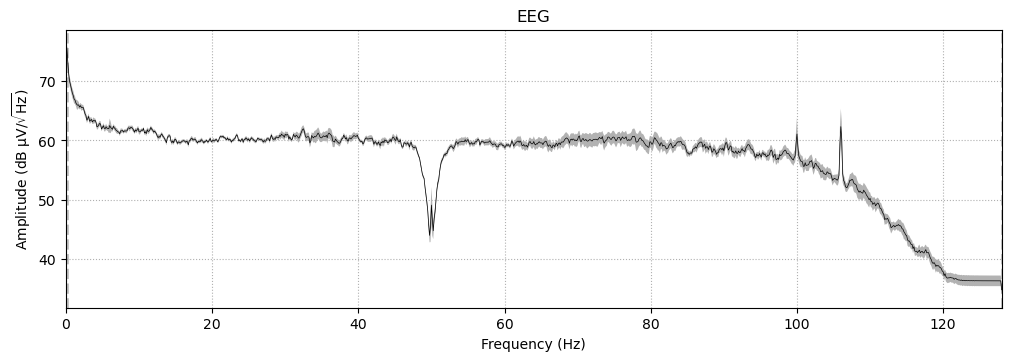

In [ ]:
participant_01_runs[0].compute_psd().plot(average=True, amplitude=True)
plt.show()

#### 2.1 Filter raw eeg data

In [ ]:
lp_filtered_eeg_data = filter_eeg_data(filtered_eeg_data_dict, hp=None, lp=30)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 113 samples (0.441 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Effective window size : 8.000 (s)
Plotting amplitude spectral density (dB=True).


/Users/diegosabajo/miniconda3/envs/neural_ml/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


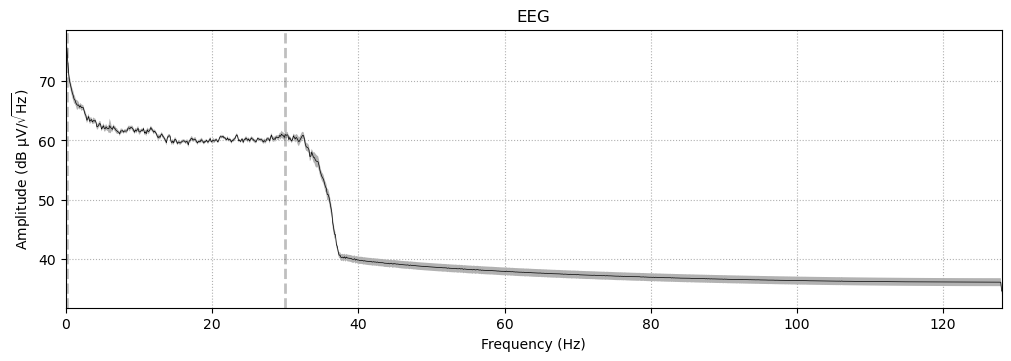

In [ ]:
participant_01_runs = participant_runs(lp_filtered_eeg_data, 'P01')
participant_01_runs[0].compute_psd().plot(average=True, amplitude=True)
plt.show()

#### 2.2 Filter for ICA Analysis

In [ ]:
eeg_ica_dict = filter_eeg_data(lp_filtered_eeg_data, hp=1, lp=30)

Effective window size : 8.000 (s)
Plotting amplitude spectral density (dB=True).


/Users/diegosabajo/miniconda3/envs/neural_ml/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


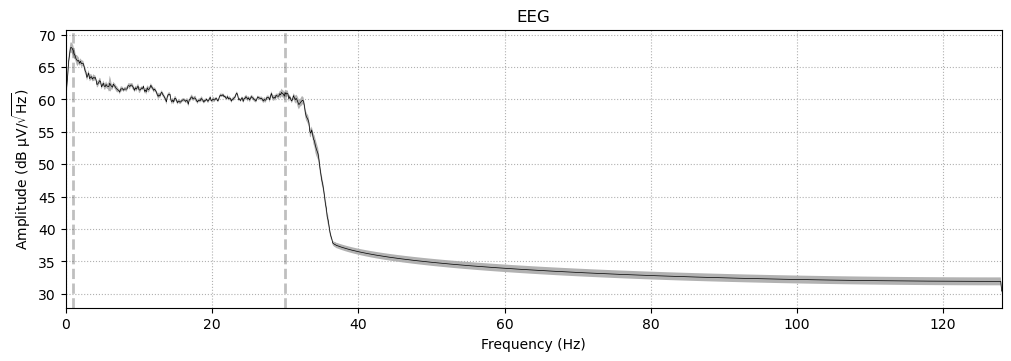

In [ ]:
participant_01_runs = participant_runs(eeg_ica_dict, 'P01')
participant_01_runs[0].compute_psd().plot(average=True, amplitude=True)
plt.show()

### 3 Saving and Loading processed raw files

#### 3.1 Saving

In [ ]:
from save_and_load import save_processed_files

baseOutputPath = './Data/'
sub_fol_name = 'Processed EEG data'
name_of_file = 'Run'

save_processed_files(baseOutputPath, sub_fol_name, name_of_file, lp_filtered_eeg_data)

Saved processed runs for P01 to ./Data/Processed EEG data/P01
Saved processed runs for P02 to ./Data/Processed EEG data/P02
Saved processed runs for P03 to ./Data/Processed EEG data/P03
Saved processed runs for P04 to ./Data/Processed EEG data/P04
Saved processed runs for P05 to ./Data/Processed EEG data/P05
Saved processed runs for P06 to ./Data/Processed EEG data/P06
Saved processed runs for P07 to ./Data/Processed EEG data/P07
Saved processed runs for P08 to ./Data/Processed EEG data/P08
Saved processed runs for P09 to ./Data/Processed EEG data/P09
Saved processed runs for P10 to ./Data/Processed EEG data/P10


#### 3.2 Loading raw Files

In [ ]:
from save_and_load import load_eeg_data

base_file_path = pathlib.Path('./Data/Processed EEG data/')
eeg_raw_dict = load_eeg_data(base_file_path)

In [ ]:
participant_P01 = get_raw_eeg(eeg_raw_dict, 'P01')

In [ ]:
participant_P01[0].plot(title='Handled Bad Channel EEG Data', block=False, scalings='50.0',
            picks='all', color='black',
          )
plt.show()

2024-06-12 00:04:33,021 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.1a1


Channels marked as bad:
none


In [ ]:
eeg_ica_dict = filter_eeg_data(eeg_raw_dict, hp=1, lp=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 H

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


### 4 Artifact detection using ICA

In [ ]:
def create_system_montage(eeg_data_dict: dict[List[Raw]]):
    montage = mne.channels.make_standard_montage('standard_1005')
    for eeg_data_list in eeg_data_dict.values():
        for eeg_data in eeg_data_list:
            eeg_data.set_montage(montage)
            # eeg_data.plot(show=True)

create_system_montage(eeg_ica_dict)

In [ ]:
participant_01_runs = get_raw_eeg(eeg_ica_dict, 'P01')

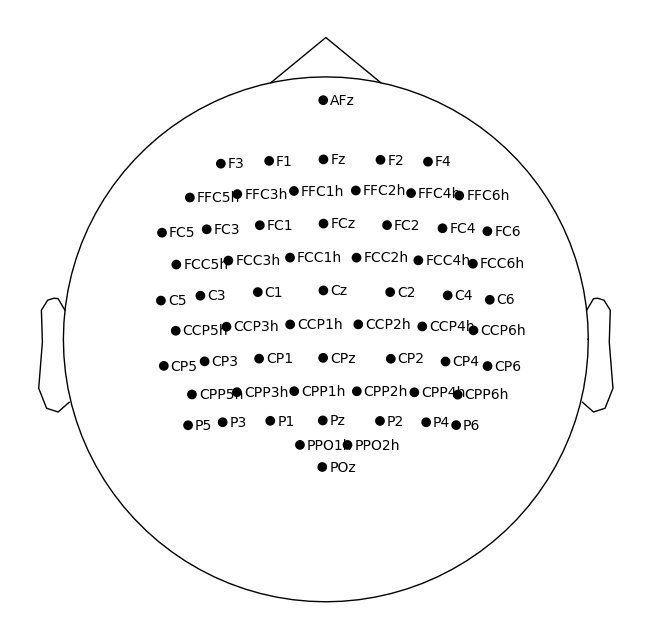

Effective window size : 8.000 (s)


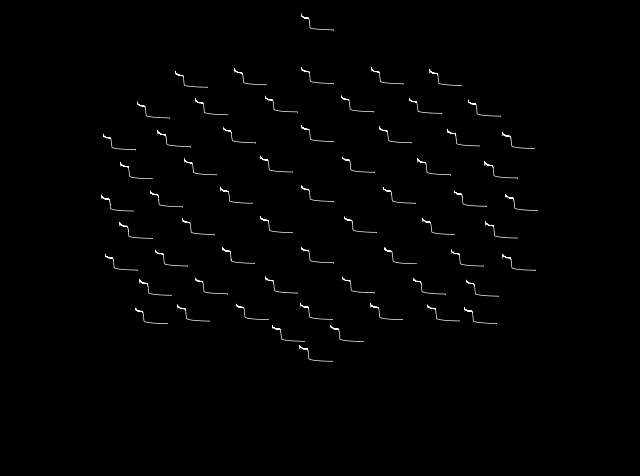

In [ ]:
participant_01_runs[1].plot_sensors(ch_type='eeg', show_names=True)
participant_01_runs[1].compute_psd().plot_topo()
plt.show()

#### 4.1. Calculating and saving ICA components

In [ ]:
class ICAProcessor: 
  def __init__(self, random_state=1, max_iter=2000, ica_class = ICA, read_ica =read_ica):
    self.random_state = random_state
    self.max_iter = max_iter
    self.ica = None
    self.ica_class = ica_class
    self.read_ica = read_ica
    
  def compute_components(self, eeg_data: Raw, n_components: int): 
    """Compute Independent Component Analysis on data"""
    self.ica = self.ica_class(
      n_components=n_components, 
      random_state=self.random_state, 
      max_iter=self.max_iter,
      method='picard',
      fit_params=dict(extended=True)
      )
    self.ica.fit(eeg_data)
    return self.ica
    
  def save_components(self, file_path: str):
    """Save ICA components to file"""
    if self.ica is None:
      raise ValueError("ICA components not computed yet")
    self.ica.save(file_path, overwrite=True)
    
  def load_components(self, file_path: str):
    """Load ICA components from file"""
    return self.read_ica(file_path)
    
  def plot_component(self, eeg_data: Raw, ica: mne.preprocessing.ica.ICA, run: int):
    """Plot ICA components for visualization"""
    ica[run].plot_components(title=f'ICA components, run {run + 1}', inst=eeg_data[run])
    plt.show()

In [ ]:
def extract_run_number(raw: Raw) -> int:
  """Extract run number from raw
  Args:
      raw (Raw): an eeg raw file
  Returns:
      int: run number
  """
  filename = raw.filenames[0]
  match = re.search(r'Run (\d+)', filename, re.IGNORECASE)
  run_idx = int(match.group(1))
  return run_idx

def compute_ica_components(eeg_data: dict[List[Raw]], baseOutputPath: str):
    """
    Processes the participants data to compute and save ICA components.

    Args:
        participants_data (List[Dict[str, List[Raw]]]): List of participant data dictionaries.
        baseOutputPath (str): The base output path for saving files.
        sub_fol_name (str): The sub-folder name for each participant.
        name_of_file (str): The base name of the file to save.
    """
    os.makedirs(baseOutputPath, exist_ok=True)
  
    for participant_id, data in eeg_data.items():
        print(f'Processing participant {participant_id}...\n')
        
        for raw in data:
          run_idx = extract_run_number(raw)
          
          ica_processor = ICAProcessor()
          print(f'  Processing run {run_idx} for participant {participant_id}')

          participant_output_path = os.path.join(f'{baseOutputPath}/{participant_id}')
          os.makedirs(participant_output_path, exist_ok=True)
          
          ica_processor.compute_components(raw, n_components=0.99)
          
          ica_filepath = os.path.join(participant_output_path, f'Run {run_idx}_ica.fif')
          ica_processor.save_components(ica_filepath)
          
          print(f'  Saved ICA components for run {run_idx} to {ica_filepath}')

baseOutputPath = './Data/Processed ICA components'
sub_fol_name = 'participant'

compute_ica_components(eeg_ica_dict, baseOutputPath)


#### 4.2 Loading ICA components

In [ ]:
def load_ica_components(baseOutputPath: str, num_participants: int, run_nums: List) -> Dict[int, List[ICA]]:
    """
    Loads the ICA components for each participant.

    Args:
        baseOutputPath (str): The base output path where files are saved.
        sub_fol_name (str): The sub-folder name for each participant.
        num_participants (int): The number of participants.

    Returns:
        Dict[int, List[ICA]]: Dictionary of participant indices and their corresponding ICA objects.
    """
    ica_processor = ICAProcessor()
    ica_components = {}

    for idx in range(1, num_participants + 1):
        
        participant_id = f'P{idx:02}'
        participant_ica_list = []
        participant_output_path = os.path.join(baseOutputPath, participant_id)
        
        for run_num in run_nums:  # Assuming each participant has 9 runs
            ica_filepath = os.path.join(participant_output_path, f'Run {run_num}_ica.fif')
            print(f'Loading ICA components from {ica_filepath}...')
            ica = ica_processor.load_components(ica_filepath)
            participant_ica_list.append(ica)
        
        ica_components[participant_id] = participant_ica_list
    
    return ica_components


# Load ICA components for each participant
baseOutputPath = './Data/Processed ICA components'
num_participants = 10
run_nums = [3, 4, 5, 6, 7, 10, 11, 12, 13]
ica_components = load_ica_components(baseOutputPath, num_participants, run_nums)

Loading ICA components from ./Data/Processed ICA components/P01/Run 3_ica.fif...
Reading ./Data/Processed ICA components/P01/Run 3_ica.fif ...
Now restoring ICA solution ...
Ready.
Loading ICA components from ./Data/Processed ICA components/P01/Run 4_ica.fif...
Reading ./Data/Processed ICA components/P01/Run 4_ica.fif ...
Now restoring ICA solution ...
Ready.
Loading ICA components from ./Data/Processed ICA components/P01/Run 5_ica.fif...
Reading ./Data/Processed ICA components/P01/Run 5_ica.fif ...
Now restoring ICA solution ...
Ready.
Loading ICA components from ./Data/Processed ICA components/P01/Run 6_ica.fif...
Reading ./Data/Processed ICA components/P01/Run 6_ica.fif ...
Now restoring ICA solution ...
Ready.
Loading ICA components from ./Data/Processed ICA components/P01/Run 7_ica.fif...
Reading ./Data/Processed ICA components/P01/Run 7_ica.fif ...
Now restoring ICA solution ...
Ready.
Loading ICA components from ./Data/Processed ICA components/P01/Run 10_ica.fif...
Reading ./Dat

#### 4.3 Plotting ICA components

In [ ]:
def prepare_ica_artifacts(eeg_data: dict[int, Raw], 
                          ica_comp: dict[int, mne.preprocessing.ICA], 
                          run: int, 
                          comp_type: str) -> None:
  """
  Prepares the data and ICA components for plotting artifacts.

  Args:
      eeg_data (dict[int, mne.io.Raw]): Dictionary of EEG data.
      ica_comp (dict[int, mne.preprocessing.ICA]): Dictionary of ICA components.
      run (int): The ID of the participant.
      comp_type (str): Type of artifact to plot ('eye' or 'muscle').
  """
  # if run not in eeg_data or run not in ica_comp:
  #     print(f"Participant {run} data or ICA components not found.")
  #     return

  eeg_data_run = eeg_data[run]
  ica = ica_comp[run]
  if comp_type == 'eye':
      indices, scores = ica.find_bads_eog(eeg_data_run, verbose=False)
  elif comp_type == 'muscle':
      indices, scores = ica.find_bads_muscle(eeg_data_run, verbose=False)
  else:
      print(f"Invalid component type: {comp_type}. Choose 'eye' or 'muscle'.")
      return

  if len(indices) == 0:
      print(f"No {comp_type} movement artifacts detected for run {run + 1}.\n")
      return
  
  plot_ica_artifacts(eeg_data_run, ica, run, indices, scores, comp_type)
  return indices

def plot_ica_artifacts(eeg_data: Raw, 
                       ica: mne.preprocessing.ICA, 
                       run: int, 
                       indices: list[int], 
                       scores: list[float], 
                       comp_type: str) -> None:
    """
    Plots ICA artifact components.

    Args:
        eeg_data (mne.io.Raw): The EEG data.
        ica (mne.preprocessing.ICA): The ICA components.
        run (int): The run of the participant.
        indices (list[int]): Indices of the bad components.
        scores (list[float]): Scores of the bad components.
        comp_type (str): Type of artifact to plot ('eye' or 'muscle').
    """
    n_indices = len(indices)
    ica.plot_scores(scores=scores, 
                    show=True, 
                    n_cols=3, 
                    figsize=(12, 5), 
                    exclude=[indices], 
                    title=f'{comp_type.capitalize()} Score, run {run + 1}')
    
    # fig, axes = plt.subplots(n_indices, 5, figsize=(18, 6))
    # if n_indices == 1:
    #     axes = np.expand_dims(axes, axis=0)

    # for i, pick in enumerate(indices):
    #     ica.plot_properties(inst=eeg_data, picks=pick, axes=axes[i], show=False, verbose=False)

    plt.tight_layout()
    plt.show()

  
def plot_eog_epochs(eeg_data: dict[int, Raw], run: int):
  """
    Plots the EOG epochs.

    Args:
        eeg_data (mne.io.Raw): The EEG data to plot.
    """
  eog_epochs = create_eog_epochs(eeg_data[run], baseline=(-0.5, -0.2), verbose=False)
  eog_epochs.plot_image(combine="mean", title=f"EOG Epochs Heatmap, Run {run + 1}")
  eog_epochs.average().plot_joint(title=f'EOG Epochs Average, Run {run + 1}')
  plt.show()

In [ ]:
def plot_component_time_series(eeg_data: List[Raw], ica_comp: List[ICA], run_idx:int, comp_idx: int):
  component_timeseries = ica_comp[run_idx].get_sources(eeg_data[run_idx]).get_data()[comp_idx]
  time_vector = np.arange(component_timeseries.size) / eeg_data[run_idx].info['sfreq']

  plt.figure(figsize=(10, 5))
  plt.plot(time_vector, component_timeseries, label='ICA Component {}'.format(comp_idx))
  plt.xlabel('Time (s)')
  plt.ylabel('AU (Arbitrary Units)')
  plt.title('Time Series of ICA Component {}'.format(comp_idx))
  plt.legend()
  plt.show()

In [ ]:
def plot_component_power_spectrum(eeg_data: List[Raw], ica_comp: List[ICA], run_idx: int, comp_idx: int):
  ica_sources = ica_comp[run_idx].get_sources(eeg_data[run_idx]).get_data()
  component_data = ica_sources[comp_idx]

  sfreq = eeg_data[run_idx].info['sfreq']

  psd, freqs = mne.time_frequency.psd_array_welch(x=component_data, sfreq=sfreq, fmin=1, fmax=40, n_fft=256)
  psd_dB = 10 * np.log10(psd)


  plt.figure(figsize=(10, 5))
  plt.plot(freqs, psd_dB, c='red', marker='o', label=f'Component {comp_idx}')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power Spectral Density (uV^2/Hz)')
  plt.title(f'Power Spectrum of ICA Component {comp_idx}')
  plt.xlim(1, 40)
  plt.legend()
  plt.show()

#### Brain components
- Scalp topography often looks dipolar
- Residual variance from dipole fit (marked RV on images) should be low. Usually below 15% unless the - component is better explained with two dipoles
- Power spectrum decreases as frequency increased (1/f)
- Power spectrum usually has peaks between 5 and 30 Hz, most often at 10 Hz
- Epoched data will likely have a visible ERP

#### Eye component
- Scalp topographies suggest ECDs near eyes
- Power concentrated at low frequencies (below 5 Hz)
- Vertical eye movement components will contain blinks in the data
- Horizontal eye movement components will look like step functions

#### Muscle component
- Power concentrated in higher frequencies (20 Hz and above)
- Can still be dipolar, but will be located outside the skull

#### Heart component
- Clear QRS complex in the data at about 1 Hz
- Near linear gradient scalp topography
- No peaks in power spectrum

#### Line component
- Strong peak in power spectrum at either 50Hz or 60Hz

#### Channel component
- Very focal scalp topography
- Large and/or consistent artifacts in the component activations.
- Easily confused with muscle components, but PSD is different.

#### Other
- Anything that doesn't fit the above categories.
- More likely the higher the IC number (as in IC 150 of 220 is very likely to be "Other")
- Non-dipolar scalp maps
- Spectrum can still have weak 10 Hz peak as brain signals are likely mixed with other signals

In [ ]:
%matplotlib qt

In [ ]:
def get_raw_eeg(eeg_dict: dict[List[Raw]], pid: str)-> List[Raw]:
  participant_eeg_data = eeg_dict.get(pid, [])
  return participant_eeg_data

def get_ica_components(ica_dict: dict[List[ICA]], pid: str)-> List[ICA]:
  ica_component = ica_dict.get(pid, [])
  return ica_component

def select_participant_n_components(pid: str, ica_components: List[ICA], eeg_data: dict[List[Raw]]) -> Tuple[List[ICA], List[Raw]]:
    ica_component = get_ica_components(ica_components, pid)
    participant_eeg_data = get_raw_eeg(eeg_data, pid)
    
    return ica_component, participant_eeg_data

In [ ]:
pid = 'P01'
ica_component, raw_for_ica = select_participant_n_components(pid, ica_components, eeg_ica_dict)

In [ ]:
run = 1 - 1
ica_processor = ICAProcessor()
ica_processor.plot_component(raw_for_ica, ica_component, run)
indices = prepare_ica_artifacts(raw_for_ica, ica_component, run, 'eye')
plot_eog_epochs(raw_for_ica, run)

Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated


/var/folders/0h/5yv3vz210dx61dfqmldvk_h40000gn/T/ipykernel_96099/1451824937.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


combining channels using "mean"
No projector specified for this dataset. Please consider the method self.add_proj.


In [ ]:
plot_component_time_series(raw_for_ica, ica_component, run, 6)

In [ ]:
ica_component[run].plot_sources(raw_for_ica[run])

Creating RawArray with float64 data, n_channels=40, n_times=75508
    Range : 0 ... 75507 =      0.000 ...   294.949 secs
Ready.


2024-06-12 14:57:36,487 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.1a1


In [ ]:
def explained_var_by_comp(run, ica_comp, eeg_data):
  for i in range(ica_comp[run].get_components().shape[1]):
    explained_var_ratio = ica_comp[run].get_explained_variance_ratio(
      eeg_data[run], components=[i], ch_type='eeg')
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(
        f"Fraction of variance in EEG signal explained by component {i}: "
        f"{ratio_percent}%"
    )
    
explained_var_by_comp(run, ica_component, raw_for_ica)

Fraction of variance in EEG signal explained by component 0: 27%
Fraction of variance in EEG signal explained by component 1: 1%
Fraction of variance in EEG signal explained by component 2: 5%
Fraction of variance in EEG signal explained by component 3: 1%
Fraction of variance in EEG signal explained by component 4: 2%
Fraction of variance in EEG signal explained by component 5: 11%
Fraction of variance in EEG signal explained by component 6: 3%
Fraction of variance in EEG signal explained by component 7: 1%
Fraction of variance in EEG signal explained by component 8: 2%
Fraction of variance in EEG signal explained by component 9: 2%
Fraction of variance in EEG signal explained by component 10: 1%
Fraction of variance in EEG signal explained by component 11: 1%
Fraction of variance in EEG signal explained by component 12: 6%
Fraction of variance in EEG signal explained by component 13: 3%
Fraction of variance in EEG signal explained by component 14: 1%
Fraction of variance in EEG signa

In [ ]:
artifact_indices = {
    "P01": {
        1: [0, 5, 6, 12],
        2: [1, 3],
        3: [0, 2, 4, 6, 13],
        4: [0, 2],
        5: [0, 1, 6],
        6: [0, 5, 7],
        7: [0, 1],
        8: [0, 2, 9],
        9: [0, 2]
    },
    "P02": {
        1: [2, 3],
        2: [2, 10],
        3: [3, 9],
        4: [9],
        5: [3, 5, 9],
        6: [2, 19],
        7: [1, 5, 11],
        8: [1, 6, 9],
        9: [1, 3]
    },
    "P03": {
        1: [0, 7],
        2: [0, 7],
        3: [0, 7],
        4: [0, 7],
        5: [0, 6, 8],
        6: [0, 6, 7],
        7: [0, 4, 10],
        8: [0, 4, 8],
        9: [0, 3, 6, 7]
    },
    "P04": {
        1: [1, 2],
        2: [0, 2, 3],
        3: [0, 1, 2],
        4: [0, 1, 3],
        5: [0, 1, 3, 5],
        6: [0, 1, 3, 8],
        7: [0, 1, 2, 3],
        8: [0, 1, 3, 4],
        9: [0, 1, 4, 5]
    },
    "P05": {
        1: [1, 6],
        2: [1, 5, 14],
        3: [0, 5, 6, 18],
        4: [2, 14],
        5: [0, 15],
        6: [1],
        7: [0, 5],
        8: [0],
        9: [0]
    },
    "P06": {
        1: [0, 5, 20],
        2: [0, 4, 8],
        3: [0, 4],
        4: [1, 7],
        5: [1, 7],
        6: [0, 4],
        7: [0, 1],
        8: [0, 7],
        9: [0, 2]
    },
    "P07": {
        1: [0, 2, 3, 4],
        2: [0, 2, 5],
        3: [0, 1, 3],
        4: [0, 2, 7],
        5: [0, 2, 3],
        6: [0, 1, 8],
        7: [0, 1, 2, 3],
        8: [1, 2, 3],
        9: [0, 1, 5]
    },
    "P08": {
        1: [0, 2],
        2: [0, 2, 3],
        3: [0, 2, 3],
        4: [0, 1, 4],
        5: [0, 2, 3],
        6: [0, 2, 3],
        7: [0, 2, 4],
        8: [0, 2, 3],
        9: [0, 2, 3]
    },
    "P09": {
        1: [0, 2],
        2: [0, 1, 3],
        3: [0, 1],
        4: [0, 1, 2, 4],
        5: [0, 5],
        6: [0, 4, 14],
        7: [0, 1, 5],
        8: [0, 5],
        9: [1, 7, 8]
    },
    "P10": {
        1: [0, 2, 8],
        2: [0, 2, 3],
        3: [0, 1, 2, 4],
        4: [0, 2, 5],
        5: [0, 1, 3, 6],
        6: [0, 1, 3],
        7: [0, 2, 4],
        8: [0, 1, 4],
        9: [0, 2, 3]
    }
}

In [ ]:
def get_raw_eeg(eeg_dict: dict[List[Raw]], pid: str)-> List[Raw]:
  participant_eeg_data = eeg_dict.get(pid, [])
  return participant_eeg_data

eeg_raw = get_raw_eeg(eeg_raw_dict, 'P01')

In [ ]:
eeg_raw[0].plot(title='Raw EEG Data', block=False, scalings='50.0',
            picks='all', color='black')

2024-06-12 23:49:23,118 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.1a1


Channels marked as bad:
none


#### 4.4 Artifact Correction

In [ ]:
def exlude_artifacts(artifact_indices: dict[List[int]], ica_components: dict[List[int]], eeg_data: dict[List[int]]):
  for participant in artifact_indices:
    ica_component, participant_eeg_data = select_participant_n_components(pid, ica_components, eeg_data)
    for run in artifact_indices[participant]:
      ica_component[run - 1].exclude = artifact_indices[participant][run]
      ica_component[run - 1].apply(participant_eeg_data[run - 1])
      
exlude_artifacts(artifact_indices, ica_components, eeg_raw_dict)

Applying ICA to Raw instance
    Transforming to ICA space (37 components)
    Zeroing out 4 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (37 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (39 components)
    Zeroing out 5 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 2 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 3 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (37 components)
    Zeroing out 3 ICA components
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (37 components)
    Zeroing ou

In [ ]:
eeg_raw[run].plot(title='Artifact Corrected', block=False, scalings='50.0',
            picks='all', color='black')


Using pyopengl with version 3.1.1a1


Channels marked as bad:
none


### 5. Setting The Reference

In [ ]:
def setting_reference(eeg_data: dict[str, list[Raw]]):
    """
    Applies average referencing to each raw EEG data run for each participant.
    Args:
        eeg_data (dict[str, list[mne.io.Raw]]): Dictionary containing raw EEG data.
    """
    for raw_list in eeg_data.values():
        for raw in raw_list:
            raw.set_eeg_reference(ref_channels='average', projection=True).apply_proj()

setting_reference(eeg_raw_dict)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channe

### 6. Save and Load artifact corrected eeg data

#### 6.1 Saving

In [ ]:
baseOutputPath = './Data/'
sub_fol_name = 'Artifact corrected EEG data'
name_of_file = 'Run'

save_processed_files(baseOutputPath, sub_fol_name, name_of_file, eeg_raw_dict)

### ==============================================**2nd Loading State**=======================================================

#### 6.2 Loading

In [1]:
from typing import List, Tuple
import numpy as np

import mne
from mne.io import Raw 
from mne.annotations import Annotations
from mne.epochs import Epochs
from mne import events_from_annotations, Epochs, Annotations

import pathlib
import matplotlib.pyplot as plt

from save_and_load import load_eeg_data

base_file_path = pathlib.Path('./Data/Artifact corrected EEG data/')
eeg_clean_P01 = load_eeg_data(base_file_path, 'P01')

eeg_clean_P01['P01'][0].info

def drop_eog_channels(eeg_data):
  for pid in eeg_data.keys():
    for run in range(len(eeg_data[pid])):
      eeg_data[pid][run].drop_channels(['eog-l', 'eog-m', 'eog-r'])
      
drop_eog_channels(eeg_clean_P01)

In [2]:
eeg_clean_P01['P01'][0].plot(title='Cleaned EEg data', block=False, scalings='50.0',
            picks='all', color='black')

Using qt as 2D backend.
Using pyopengl with version 3.1.1a1


Channels marked as bad:
none


### 7. Segmenting Data into Epochs

In [3]:
hexa_dec = [{"event_code": "0x300", "event_description": "trial start"}, 
            {"event_code": "0x311", "event_description": "beep"}, 
            {"event_code": "0x312", "event_description": "fixation cross"}, 
            {"event_code": "0x308", "event_description": "supination class cue"}, 
            {"event_code": "0x309", "event_description": "pronation class cue"}, 
            {"event_code": "0x30B", "event_description": "hand open class cue"}, 
            {"event_code": "0x39D", "event_description": "palmar grasp class cue"}, 
            {"event_code": "0x39E", "event_description": "lateral grasp class cue"}]

for i in hexa_dec:
  print(i['event_code'], int(i['event_code'], 16), i['event_description'])
  
hand_movement_events = {
    776: 'supination',
    777: 'pronation',
    779: 'hand_open',
    925: 'palmar_grasp',
    926: 'lateral_grasp',
}
event_id_to_description = {v: k for k, v in hand_movement_events.items()}
event_id_to_description

0x300 768 trial start
0x311 785 beep
0x312 786 fixation cross
0x308 776 supination class cue
0x309 777 pronation class cue
0x30B 779 hand open class cue
0x39D 925 palmar grasp class cue
0x39E 926 lateral grasp class cue


{'supination': 776,
 'pronation': 777,
 'hand_open': 779,
 'palmar_grasp': 925,
 'lateral_grasp': 926}

In [4]:
def filter_events(annotations: Annotations, hand_movement_events: dict[int, str]) -> List[Annotations]:
    filtered_annotations = []
    for onset, duration, description in zip(annotations.onset, annotations.duration, annotations.description):
        event_id = int(description)
        if event_id in hand_movement_events:
            filtered_annotations.append((onset, duration, hand_movement_events[event_id]))
    return filtered_annotations

def create_epochs(raw: Raw, 
                  filtered_annotations: List[Annotations], 
                  event_id_to_description: dict[int, str], 
                  baseline: Tuple[None, int]) -> Epochs:
  
    filtered_annotations = Annotations(
        onset=[fa[0] for fa in filtered_annotations],
        duration=[fa[1] for fa in filtered_annotations],
        description=[fa[2] for fa in filtered_annotations]
    )
    raw.set_annotations(filtered_annotations)
    events, event_id = events_from_annotations(raw, event_id=event_id_to_description)
    epochs = Epochs(raw, events, event_id=event_id, reject_by_annotation=True, tmin=-2, tmax=4, baseline=baseline, preload=True)
    epochs.apply_baseline(baseline=baseline)
    return epochs
  
epochs_list = []
labels_list = []
raw_epochs = []

for participant, runs in eeg_clean_P01.items():
    for run in runs:
        raw = run
        filtered_annotations = filter_events(raw.annotations, hand_movement_events)
        epochs = create_epochs(raw, filtered_annotations, event_id_to_description, baseline=(-0.2, 0))
        epochs_list.append(epochs.get_data(copy=False))
        labels_list.append(epochs.events[:, -1])
        raw_epochs.append(epochs)

all_epochs = np.concatenate(epochs_list, axis=0)
all_labels = np.concatenate(labels_list, axis=0)

Used Annotations descriptions: ['hand_open', 'lateral_grasp', 'palmar_grasp', 'pronation', 'supination']


Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 1537 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Used Annotations descriptions: ['hand_open', 'lateral_grasp', 'palmar_grasp', 'pronation', 'supination']
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 1537 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Used Annotations descriptions: ['hand_open', 'lateral_grasp', 'palmar_grasp', 'pronation', 'supination']
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data

In [5]:
print(len(all_epochs), len(all_labels))
print(len(all_epochs), len(all_labels))
print(all_epochs.shape)

360 360
360 360
(360, 61, 1537)


In [8]:
%matplotlib qt

raw_epochs[0].compute_psd().plot(picks='eeg', amplitude=False)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


- Delta pattern (0.5 - 4Hz) corresponds to deep sleep when the subject has lower awareness
- Theta pattern (4 - 8Hz) corresponds to light sleep in the realm of low awareness
- Alpha pattern (8 - 12Hz) mainly occurs during eyes closed and deeply relaxed state and corresponds to the medium awareness
- Beta pattern (12 - 30Hz) is the dominant rhythm while the eyes of the subject are open and is asssociated with high awareness. Beta patterns capture most of our daily activities (such as eating, walking, and talking)
- Gamma pattern (30 - 100Hz) represents the co-interaction of several brain areas to carry out a specific motor and cognitive function

- For the task at hand of classifying hand movements we focus on the Theta, Alpha and Beta patterns

- The Delta pattern isn't relevant for the task at hand of classifying hand movements and the Gamma pattern is basically filtered out.

    Using multitaper spectrum estimation with 7 DPSS windows
converting legacy list-of-tuples input to a dict for the `bands` parameter


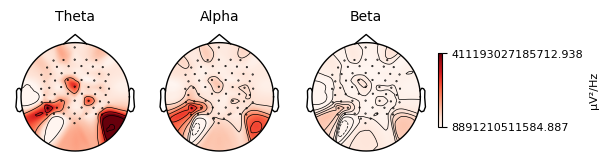

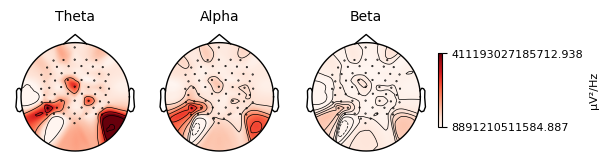

In [5]:
bands = [(4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 30, 'Beta')]
raw_epochs[2].compute_psd().plot_topomap(bands=bands, vlim='joint')

### 8. Channel selection

In [25]:
import numpy as np

def select_channels_variance(data, num_channels):
  """
  Selects channels based on their variance.

  Args:
    data: EEG data, shape (num_epochs, num_channels, num_samples)
    num_channels: Number of channels to select

  Returns:
    Indices of selected channels
  """

  channel_variance = np.var(data, axis=(0, 2))
  sorted_indices = np.argsort(channel_variance)[::-1]
  print(sorted_indices)
  selected_channels_indx = sorted_indices[:num_channels]

  return selected_channels_indx


In [26]:
print(all_epochs.shape)
selected_channels = select_channels_variance(all_epochs, 10)
print(selected_channels, selected_channels.shape)


(360, 61, 1537)
[ 5 10 17 28 45 50  6 25 11  7  4 51 18 57  1 29  2 49 60 39 19 13 21 35
  0 46 31 15 44  9 12 33 58 30 43 55 34  8 53 36 37 47 14  3 26 24 16 56
 38 52 54 41 32 59 22 42 20 48 40 23 27]
[ 5 10 17 28 45 50  6 25 11  7] (10,)


### 8. Feature Extraction

In [10]:

example_raw = next(iter(eeg_clean_P01.values()))[0]
sfreq = example_raw.info['sfreq']
info = example_raw.info

print(type(info))
frequencies = np.concatenate([
                np.arange(8, 13, 0.5),  # Mu and Alpha bands with 0.5 Hz step
                np.arange(12, 30, 1)])
                
print(type(frequencies))
print(type(sfreq))


<class 'mne._fiff.meas_info.Info'>
<class 'numpy.ndarray'>
<class 'float'>


In [5]:
from feature_extraction import EEGFeatureExtractor

example_raw = next(iter(eeg_clean_P01.values()))[0]
sfreq = example_raw.info['sfreq']
info = example_raw.info
event_id = event_id_to_description
frequencies = np.concatenate([
                np.arange(8, 13, 0.5),  # Alpha freq
                np.arange(13, 30, 1)    # Mu freq
            ])                                                              

extractor = EEGFeatureExtractor(info=info, frequencies=frequencies, event_id=event_id)
# Time Domain Features
time_methods =['mean', 'median', 'max', 'min', 'std', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zero_crossings']
time_features_list = np.array([extractor.extract_time_features(epoch, time_methods) for epoch in all_epochs])

# # Frequency Domain Features
# frequency_methods = []
# extractor = EEGFeatureExtractor(info=info, frequencies=frequencies, methods=time_methods, event_id=event_id)
# frequency_features_list = np.array([extractor.extract_frequency_features(epoch, sfreq) for epoch in all_epochs])

# # Time-Frequency Domain Features
# time_frequency_methods = []
# extractor = EEGFeatureExtractor(info=info, frequencies=frequencies, methods=time_frequency_methods, event_id=event_id)
# time_frequency_features_list = np.array([extractor.extract_time_frequency_features(epoch, sfreq) for epoch in all_epochs])

# # Spatial Domain Features
# spatial_domain_methods = []
# extractor = EEGFeatureExtractor(info=info, frequencies=frequencies, methods=spatial_domain_methods, event_id=event_id)
# spatial_features_list = np.array([extractor.extract_spatial_features(all_epochs, all_labels, epoch, sfreq) for epoch in all_epochs])

Extracting time domain featues:
 - Extracting Mean feature...
 Time elapsed: 0.0002 seconds
 - Extracting Median feature...
 Time elapsed: 0.0008 seconds
 - Extracting Max feature...
 Time elapsed: 0.0000 seconds
 - Extracting Min feature...
 Time elapsed: 0.0000 seconds
 - Extracting Std feature...
 Time elapsed: 0.0001 seconds
 - Extracting Var feature...
 Time elapsed: 0.0002 seconds
 - Extracting Skew feature...
 Time elapsed: 0.0010 seconds
 - Extracting Kurt feature...
 Time elapsed: 0.0008 seconds
 - Extracting Ptp feature...
 Time elapsed: 0.0000 seconds
 - Extracting Rms feature...
 Time elapsed: 0.0001 seconds
 - Extracting Zero_crossings feature...
 Time elapsed: 0.0001 seconds
Feature extraction completed,
Extracting time domain featues:
 - Extracting Mean feature...
 Time elapsed: 0.0001 seconds
 - Extracting Median feature...
 Time elapsed: 0.0009 seconds
 - Extracting Max feature...
 Time elapsed: 0.0000 seconds
 - Extracting Min feature...
 Time elapsed: 0.0000 seconds


In [6]:
print(time_features_list.shape)
# print(frequency_features_list.shape)
# print(time_frequency_features_list.shape)
# print(spatial_features_list.shape)

(360, 671)


In [8]:
import numpy as np
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [9]:
class SaveAndLoadFeatures:
  def __init__(self, features=None):
    self.features = features
    
  def save_features(self, path):
    if self.features is not None:
      features_df = pd.DataFrame(self.features)
      features_df.to_csv(path, index=False) 
    else:
      raise ValueError("No features to save.")
    
  def load_features_csv(self, path):
    # self.features = np.load(path, allow_pickle=True)
    features_df = pd.read_csv(path)
    return features_df
  
  def load_features_npy(self, path):
    self.features = np.load(path)
    return self.features
    
  def __len__(self):
    if self.features is not None:
      return len(self.features)
    else:
      raise ValueError("Features not loaded")
      
  def __getitem__(self, idx):
    if self.features is not None:
      return self.features[idx]
    else:
      raise ValueError("Features not loaded")


In [10]:
# save time featues
save_feat = SaveAndLoadFeatures(time_features_list)
save_feat.save_features('./Data/Features/time_features.csv')

# save frequency features
save_feat = SaveAndLoadFeatures(frequency_features_list)
save_feat.save_features('./Data/Features/frequency_features.csv')

# save time frequency features
save_feat = SaveAndLoadFeatures(time_frequency_features_list)
save_feat.save_features('./Data/Features/time_frequency_features.csv')

# save spatial features
save_feat = SaveAndLoadFeatures(spatial_features_list)
save_feat.save_features('./Data/Features/spatial_features.csv')

In [11]:
save_labels = SaveAndLoadFeatures(all_labels)
save_labels.save_features('./Data/Labels/all_labels.csv')

In [12]:
load_feat = SaveAndLoadFeatures()
time_feats_df = load_feat.load_features_csv('./Data/Features/time_features.csv')

load_feat = SaveAndLoadFeatures()
freq_feats_df = load_feat.load_features_csv('./Data/Features/frequency_features.csv')

load_feat = SaveAndLoadFeatures()
time_freq_feats_df = load_feat.load_features_csv('./Data/Features/time_frequency_features.csv')

load_feat = SaveAndLoadFeatures()
spatial_feats_df = load_feat.load_features_csv('./Data/Features/spatial_features.csv')

In [13]:
load_labels = SaveAndLoadFeatures()
all_labels = load_labels.load_features_csv('./Data/Labels/all_labels.csv')

In [14]:
print(time_feats_df.shape)
print(freq_feats_df.shape)
print(time_freq_feats_df.shape)
print(spatial_feats_df.shape)

(360, 488)
(360, 244)
(360, 199606)
(360, 1541)


In [15]:
time_feats_df['classes'] = all_labels
freq_feats_df['classes'] = all_labels
time_freq_feats_df['classes'] = all_labels
spatial_feats_df['classes'] = all_labels

time_feats_df.head()


,0,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,classes
0,7.156045,10.015653,100.313311,0.212963,-0.949407,12.309439,45.360972,36.0,10.195985,6.644352,...,40.0,-7.504611,7.499374,56.240613,-0.293296,-1.214695,10.609420,30.607675,68.0,777
1,8.944105,8.939888,79.921602,-0.104139,-1.428113,12.645893,32.761292,31.0,-4.661600,6.147251,...,75.0,-3.522885,4.735739,22.427228,0.049606,-0.802483,5.902368,22.969479,67.0,779
2,-0.845963,3.145265,9.892694,0.268420,0.049376,3.257046,18.059800,93.0,-7.803537,7.285894,...,74.0,-2.922257,5.503203,30.285245,-0.712861,-0.144733,6.230957,26.419901,107.0,776
3,5.542344,4.659874,21.714422,-0.266056,-1.004263,7.240994,21.077312,36.0,-9.371311,10.761917,...,49.0,10.964438,10.876509,118.298440,0.433345,-1.151095,15.444007,42.971027,40.0,926
4,8.121382,5.353071,28.655373,-0.132773,-0.937392,9.726881,24.969655,20.0,-10.093035,11.791075,...,35.0,-2.713114,7.357131,54.127375,0.418261,-0.514033,7.841451,31.860848,43.0,776


In [ ]:
time_feats_drop_classes = time_feats_df.drop(columns='classes')
freq_feats_drop_classes = freq_feats_df.drop(columns='classes')
time_freq_feats_drop_classes = time_freq_feats_df.drop(columns='classes')
spatial_feats_drop_classes = spatial_feats_df.drop(columns='classes')

time_feats_aggregated = np.mean(time_feats_drop_classes, axis=1) 
freq_feats_aggregated = np.mean(freq_feats_drop_classes, axis=1)
time_freq_feats_aggregated = np.mean(time_freq_feats_drop_classes, axis=1) 
spatial_feats_aggregated = np.mean(spatial_feats_drop_classes, axis=1)

data = pd.DataFrame({
    'Time': time_feats_aggregated,
    'Frequency': freq_feats_aggregated,
    'Time-Frequency': time_freq_feats_aggregated,
    'Spatial': spatial_feats_aggregated,
    'Labels': all_labels
})

sns.pairplot(data=data, hue='Labels', diag_kind='hist', palette='tab10', height=4)
plt.suptitle('Pairplot of Aggregated Features', y=1.02)
plt.show()



In [9]:
def std_outlier_detection(df, feat_name):
  for cols in df.columns:
    if cols == 'classes':
      continue
    feature_mean, feature_std = np.mean(df[cols]), np.std(df[cols])
    cut_off = feature_std * 3 
    lower, upper = feature_mean - cut_off, feature_mean + cut_off
    outliers = [x for x in df[cols] if x < lower  or x > upper]
    # outliers_removed = [x for x in df[cols] if x > lower and x < upper]
    outliers_removed = df[(df[cols] >= lower) & (df[cols] <= upper)]
  print(f'Identified: %d outliers in {feat_name}' % len(outliers))
  print('Non-outlier observations: %d' % len(outliers_removed))
  return outliers_removed

In [10]:
time_feats_std_cleaned = std_outlier_detection(time_feats_df, 'time features')
freq_feats_std_cleaned = std_outlier_detection(freq_feats_df, 'frequency features')
time_freq_feats_std_cleaned = std_outlier_detection(time_freq_feats_df, 'time frequency features')
spatial_feats_std_cleaned = std_outlier_detection(spatial_feats_df, 'spatial features')

Identified: 3 outliers in time features
Non-outlier observations: 357
Identified: 2 outliers in frequency features
Non-outlier observations: 358
Identified: 8 outliers in time frequency features
Non-outlier observations: 352
Identified: 1 outliers in spatial features
Non-outlier observations: 359


In [11]:
print(time_feats_std_cleaned.shape)
print(freq_feats_std_cleaned.shape)
print(time_freq_feats_std_cleaned.shape)
print(spatial_feats_std_cleaned.shape)

(357, 489)
(358, 245)
(352, 3417)
(359, 1542)


In [16]:
def iqr_outlier_detection(df, feat_name):
  for cols in df.columns:
    if cols == 'classes':
      continue
    q25, q75 = np.percentile(df[cols], 25), np.percentile(df[cols], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in df[cols] if x < lower  or x > upper]
    # outliers_removed = [x for x in df[cols] if x > lower and x < upper]
    outliers_removed = df[(df[cols] >= lower) & (df[cols] <= upper)]
  print(f'Identified: %d outliers in {feat_name}' % len(outliers))
  print('Non-outlier observations: %d' % len(outliers_removed))
  return outliers_removed

In [17]:
time_feats_iqr_cleaned = iqr_outlier_detection(time_feats_df, 'time features')
freq_feats_iqr_cleaned = iqr_outlier_detection(freq_feats_df, 'frequency features')
time_freats_iqr_cleaned = iqr_outlier_detection(time_freq_feats_df, 'time frequency features')
spatial_feats_iqr_cleaned = iqr_outlier_detection(spatial_feats_df, 'spatial features')

Identified: 6 outliers in time features
Non-outlier observations: 354
Identified: 3 outliers in frequency features
Non-outlier observations: 357


KeyboardInterrupt: 

In [ ]:
print(time_feats_iqr_cleaned.shape)
print(freq_feats_iqr_cleaned.shape)
print(time_freats_iqr_cleaned.shape)
print(spatial_feats_iqr_cleaned.shape)

(354, 489)
(357, 245)
(331, 1540)
(356, 1542)


In [ ]:
def average_skewness(df, domain_name):
  total_skew = []
  for col in df.columns:
    if col == 'classes':
      continue
    skewness_value = skew(df[col])
    total_skew.append(skewness_value)
  print(f'Average skewness of the {domain_name} features {np.mean(total_skew)}')

In [ ]:
average_skewness(time_feats_iqr_cleaned, 'time domain')
average_skewness(freq_feats_iqr_cleaned, 'frequency domain')
average_skewness(time_freats_iqr_cleaned, 'time frequency domain')
average_skewness(spatial_feats_iqr_cleaned, 'spatial domain')

Average skewness of the time domain features 1.5063032028024421
Average skewness of the frequency domain features 2.4088210590741688
Average skewness of the time frequency domain features 6.916021751935388
Average skewness of the spatial domain features -0.005716943189358568


In [ ]:
def check_normality_and_transform(df):
    transformed_features = pd.DataFrame(index=df.index, columns=df.columns)
    
    for feature in df.columns:
        if feature == 'classes':
            transformed_features[feature] = df[feature]
            continue
        
        k2, p = stats.normaltest(df[feature])
        
        if p < 0.05: 
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_feature = pt.fit_transform(df[[feature]])
            transformed_features[feature] = transformed_feature[:, 0]
        else:
            transformed_features[feature] = df[feature]
    
    return transformed_features

In [ ]:
# Transform and normalize features
time_feats_transformed = check_normality_and_transform(time_feats_iqr_cleaned)
freq_feats_transformed = check_normality_and_transform(freq_feats_iqr_cleaned)
time_freq_feats_transformed = check_normality_and_transform(time_freats_iqr_cleaned)
spatial_feats_transformed = check_normality_and_transform(spatial_feats_iqr_cleaned)

In [ ]:
time_feats_transformed
freq_feats_transformed
time_freq_feats_transformed

,0,1,2,3,4,5,6,7,8,9,...,1530,1531,1532,1533,1534,1535,1536,1537,1538,classes
0,2.847528,2.826707,2.790589,2.730153,2.620819,2.420176,2.100219,1.716802,1.387066,1.171548,...,40.963507,64.742617,77.554101,85.134546,91.906815,98.863428,105.742706,111.958801,116.905243,777
1,2.832436,2.810723,2.773600,2.712123,2.602110,2.402116,2.085168,1.706359,1.380503,1.167155,...,36.291308,55.056332,64.803655,70.503379,75.568603,80.713063,85.709361,90.103888,93.444035,779
2,2.765676,2.747872,2.714421,2.656975,2.552599,2.361543,2.056967,1.690190,1.372060,1.162339,...,35.792626,54.018820,63.462013,69.053553,74.099291,79.269071,84.321064,88.795177,92.233498,776
3,2.633654,2.621349,2.593976,2.544536,2.452648,2.281593,2.003726,1.661800,1.358980,1.156295,...,40.159390,62.690348,74.087400,80.198985,85.370716,90.582215,95.630319,100.029950,103.293060,926
4,2.874892,2.847000,2.802976,2.733514,2.614311,2.404935,2.081232,1.700416,1.375535,1.163492,...,39.104846,59.403284,69.035607,74.104950,78.593237,83.299496,87.971160,92.120056,95.266513,776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2.730552,2.718612,2.692525,2.644668,2.552454,2.374488,2.078779,1.712472,1.389902,1.176386,...,37.447153,57.466005,67.759166,73.548607,78.573435,83.652136,88.575455,92.885896,96.123684,926
356,2.780406,2.760507,2.724457,2.663576,2.554648,2.358288,2.049435,1.681290,1.363888,1.154891,...,37.050111,55.796518,64.879993,69.756259,73.996767,78.329577,82.535573,86.184134,88.854917,926
357,2.695942,2.674794,2.637489,2.576451,2.470945,2.285346,1.995925,1.649309,1.346994,1.145749,...,33.041295,48.451995,56.053837,60.433232,64.403517,68.495496,72.485987,75.982978,78.605391,779
358,2.727723,2.709118,2.674746,2.616776,2.513519,2.327214,2.031896,1.675653,1.364911,1.158942,...,30.805759,44.612292,51.634785,55.843686,59.649705,63.506691,67.215286,70.427949,72.807182,776


In [ ]:
average_skewness(time_feats_transformed, 'time domain')
average_skewness(freq_feats_transformed, 'frequency domain')
average_skewness(time_freq_feats_transformed, 'time frequency domain')
average_skewness(spatial_feats_transformed, 'spatial domain')

Average skewness of the time domain features 0.016190546576917573
Average skewness of the frequency domain features 0.022742808888935574
Average skewness of the time frequency domain features -0.0010048318413559193
Average skewness of the spatial domain features -0.330899775375556


In [ ]:
# Remove the 'classes' column from each DataFrame
time_features = time_feats_transformed.drop(columns='classes')
time_labels = time_feats_transformed['classes']

freq_features = freq_feats_transformed.drop(columns='classes')
freq_labels = freq_feats_transformed['classes']

time_freq_features = time_freq_feats_transformed.drop(columns='classes')
time_freq_labels = time_freq_feats_transformed['classes']

spatial_features = spatial_feats_transformed.drop(columns='classes')
spatial_labels = spatial_feats_transformed['classes']

# Aligning the indices
common_indices = time_features.index.intersection(freq_features.index)
common_indices = common_indices.intersection(time_freq_features.index)
common_indices = common_indices.intersection(spatial_features.index)

# Filter datasets to only include common indices
time_aligned = time_features.loc[common_indices]
freq_aligned = freq_features.loc[common_indices]
time_freq_aligned = time_freq_features.loc[common_indices]
spatial_aligned = spatial_features.loc[common_indices]

# Extract the labels for the common indices
labels = time_labels.loc[common_indices]

# Combine the features
combined_features = pd.concat([
    time_aligned.reset_index(drop=True),
    freq_aligned.reset_index(drop=True),
    time_freq_aligned.reset_index(drop=True),
    spatial_aligned.reset_index(drop=True)
], axis=1)

print("Combined features shape:", combined_features.shape)
print("Labels shape:", labels.shape)

Combined features shape: (322, 3812)
Labels shape: (322,)


In [ ]:
combined_features

,0,1,2,3,4,5,6,7,8,9,...,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540
0,7.156045,1.893129,4.046269,0.212963,-1.359196,2.192103,2.725742,9.707586,10.195985,1.513565,...,-2.166563e-16,1.769698e-15,-6.832142e-16,2.275284e-16,1.332737e-15,6.774242e-16,-1.745416,0.221899,-0.124303,1.007277
1,8.944105,1.829771,3.873665,-0.104139,-2.348400,2.209805,2.567830,8.913802,-4.661600,1.477140,...,-1.343269e-15,-6.642591e-16,0.000000e+00,1.105138e-15,-1.776765e-15,-0.000000e+00,-0.828422,-1.416761,0.047833,-2.379503
2,-0.845963,1.232645,2.228584,0.268420,0.048281,1.318332,2.258013,16.364026,-7.803537,1.556244,...,6.751556e-16,8.848488e-16,-6.832142e-16,-0.000000e+00,-6.566304e-16,0.000000e+00,-1.286500,-0.695256,-1.692941,1.430062
3,5.542344,1.457709,2.853995,-0.266056,-1.462356,1.840633,2.340889,9.707586,-9.371311,1.729995,...,-6.499689e-16,-0.000000e+00,-3.586874e-15,-1.763025e-15,-2.433395e-15,3.500025e-15,-0.282699,-0.612246,-1.573637,-0.563509
4,8.121382,1.537600,3.074336,-0.132773,-1.336955,2.036685,2.429808,6.900542,-10.093035,1.768903,...,8.883627e-16,-8.856789e-16,9.516197e-16,-0.000000e+00,1.776982e-15,-0.000000e+00,1.559908,-1.776672,-0.385422,-0.398326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-3.431522,1.601940,3.251132,0.060501,-0.717839,1.808619,2.492721,11.142508,5.306390,1.473548,...,-1.776582e-15,1.990910e-15,-0.000000e+00,-9.020128e-16,-1.545013e-15,2.709697e-15,0.278421,0.024619,-1.340273,-1.935131
318,-3.712658,1.254326,2.289057,0.098603,-1.024405,1.588239,2.202305,11.409757,1.964505,1.445289,...,4.264141e-16,8.848488e-16,3.172066e-16,4.550567e-16,8.884910e-16,2.258081e-16,-2.881022,-0.664883,-0.978643,-1.039589
319,-0.780237,1.351900,2.560734,-0.491451,-0.314912,1.442376,2.279172,12.905946,1.556888,1.501217,...,-0.000000e+00,-8.856789e-16,-1.708035e-16,-0.000000e+00,6.515601e-16,1.129040e-15,-0.519456,-0.995398,-2.391537,-1.281077
320,-3.294727,1.099630,1.857734,-0.252840,0.061449,1.469447,2.115974,10.009361,-2.838648,1.340334,...,-2.166563e-16,-4.428394e-16,-1.708035e-16,2.275284e-16,-4.248785e-16,9.032323e-16,-0.735279,-2.197743,-1.643501,-0.878825


In [28]:
def box_plot(features, feat_name):
  plt.figure(figsize=(8, 6))
  sns.boxplot(data=features, palette='tab10')
  plt.title(f'Boxplot of {feat_name}')
  plt.show()
  

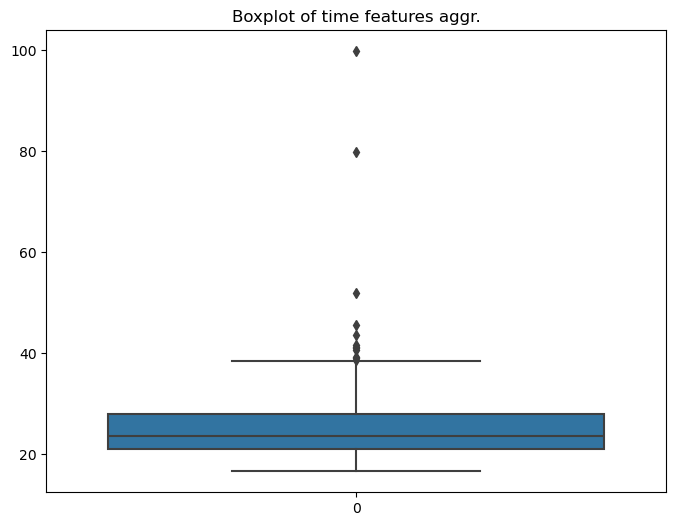

In [55]:
box_plot(time_feats_aggregated, 'time features aggr.')

In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# List of feature columns (assuming 'classes' is your non-feature column)
time_feat_cols = [col for col in time_feats_transformed.columns if col != 'classes']
freq_feat_cols = [col for col in freq_feats_transformed.columns if col != 'classes']
time_freq_cols = [col for col in time_freq_feats_transformed.columns if col != 'classes']
spatial_feat_cols = [col for col in spatial_feats_transformed.columns if col != 'classes']

# Scale only the feature columns
scaled_time_feat = scaler.fit_transform(time_feats_transformed[time_feat_cols])
time_var = np.var(scaled_time_feat, axis=0)

scaled_freq_feat = scaler.fit_transform(freq_feats_transformed[freq_feat_cols])
freq_var = np.var(scaled_freq_feat, axis=0)

scaled_time_freq_feat = scaler.fit_transform(time_freq_feats_transformed[time_freq_cols])
time_freq_var = np.var(scaled_time_freq_feat, axis=0)

scaled_spatial_feat = scaler.fit_transform(spatial_feats_transformed[spatial_feat_cols])
spatial_var = np.var(scaled_spatial_feat, axis=0)


# Step 2: Visualize variances
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.hist(time_var, bins=50)
plt.title('Time Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Count')

plt.subplot(1, 4, 2)
plt.hist(freq_var, bins=50)
plt.title('Frequency Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Count')

plt.subplot(1, 4, 3)
plt.hist(time_freq_var, bins=50)
plt.title('Time-Frequency Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Count')

plt.subplot(1, 4, 4)
plt.hist(spatial_var, bins=50)
plt.title('Spatial Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [37]:
time_features = time_feats_transformed.drop(columns='classes')
time_labels = time_feats_transformed['classes']

freq_features = freq_feats_transformed.drop(columns='classes')
freq_labels = freq_feats_transformed['classes']

time_freq_features = time_freq_feats_transformed.drop(columns='classes')
time_freq_labels = time_freq_feats_transformed['classes']

spatial_features = spatial_feats_transformed.drop(columns='classes')
spatial_labels = spatial_feats_transformed['classes']

In [ ]:
combined_features

,0,1,2,3,4,5,6,7,8,9,...,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540
0,7.156045,1.893129,4.046269,0.212963,-1.359196,2.192103,2.725742,9.707586,10.195985,1.513565,...,-2.166563e-16,1.769698e-15,-6.832142e-16,2.275284e-16,1.332737e-15,6.774242e-16,-1.745416,0.221899,-0.124303,1.007277
1,8.944105,1.829771,3.873665,-0.104139,-2.348400,2.209805,2.567830,8.913802,-4.661600,1.477140,...,-1.343269e-15,-6.642591e-16,0.000000e+00,1.105138e-15,-1.776765e-15,-0.000000e+00,-0.828422,-1.416761,0.047833,-2.379503
2,-0.845963,1.232645,2.228584,0.268420,0.048281,1.318332,2.258013,16.364026,-7.803537,1.556244,...,6.751556e-16,8.848488e-16,-6.832142e-16,-0.000000e+00,-6.566304e-16,0.000000e+00,-1.286500,-0.695256,-1.692941,1.430062
3,5.542344,1.457709,2.853995,-0.266056,-1.462356,1.840633,2.340889,9.707586,-9.371311,1.729995,...,-6.499689e-16,-0.000000e+00,-3.586874e-15,-1.763025e-15,-2.433395e-15,3.500025e-15,-0.282699,-0.612246,-1.573637,-0.563509
4,8.121382,1.537600,3.074336,-0.132773,-1.336955,2.036685,2.429808,6.900542,-10.093035,1.768903,...,8.883627e-16,-8.856789e-16,9.516197e-16,-0.000000e+00,1.776982e-15,-0.000000e+00,1.559908,-1.776672,-0.385422,-0.398326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-3.431522,1.601940,3.251132,0.060501,-0.717839,1.808619,2.492721,11.142508,5.306390,1.473548,...,-1.776582e-15,1.990910e-15,-0.000000e+00,-9.020128e-16,-1.545013e-15,2.709697e-15,0.278421,0.024619,-1.340273,-1.935131
318,-3.712658,1.254326,2.289057,0.098603,-1.024405,1.588239,2.202305,11.409757,1.964505,1.445289,...,4.264141e-16,8.848488e-16,3.172066e-16,4.550567e-16,8.884910e-16,2.258081e-16,-2.881022,-0.664883,-0.978643,-1.039589
319,-0.780237,1.351900,2.560734,-0.491451,-0.314912,1.442376,2.279172,12.905946,1.556888,1.501217,...,-0.000000e+00,-8.856789e-16,-1.708035e-16,-0.000000e+00,6.515601e-16,1.129040e-15,-0.519456,-0.995398,-2.391537,-1.281077
320,-3.294727,1.099630,1.857734,-0.252840,0.061449,1.469447,2.115974,10.009361,-2.838648,1.340334,...,-2.166563e-16,-4.428394e-16,-1.708035e-16,2.275284e-16,-4.248785e-16,9.032323e-16,-0.735279,-2.197743,-1.643501,-0.878825


In [ ]:
combined_features.shape

(322, 3812)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

def create_pipeline(k_best, rfe_features, pca_components, classifier):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('variance_threshold', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(mutual_info_classif, k=k_best)),
        ('rfe', RFE(LogisticRegression(max_iter=1000), n_features_to_select=rfe_features)),
        ('pca', PCA(n_components=pca_components)),
        ('classifier', classifier)
    ])

def perform_grid_search(features, y):
    param_grid = {
        'select_kbest__k': [50, 60, 70, 80],
        'rfe__n_features_to_select': [30, 40, 50],
        'pca__n_components': [10, 20, 30],
        'classifier': [
            LogisticRegression(max_iter=100),
        ]
    }
    pipeline = create_pipeline(k_best=70, rfe_features=50, pca_components=30, classifier=LogisticRegression())
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, scoring='accuracy', n_iter=50)
    random_search.fit(features, y)
    
    return random_search.best_params_, random_search.best_score_

feature_sets = {
   'combined_features': combined_features
}

best_params_results = {}
best_scores_results = {}

for name, features in feature_sets.items():
    print(f"Performing grid search for {name}...")
    best_params, best_score = perform_grid_search(features, labels)
    best_params_results[name] = best_params
    best_scores_results[name] = best_score
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best cross-validation accuracy for {name}: {best_score}")

# Print all results
print("\nSummary of best parameters and scores:")
for name in feature_sets.keys():
    print(f"{name}:")
    print(f"  Best parameters: {best_params_results[name]}")
    print(f"  Best cross-validation accuracy: {best_scores_results[name]}")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

def evaluate_step(data, labels, step_name):
    rf_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=1, penalty='l2')
    scores = cross_val_score(rf_model, data, labels, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Accuracy after {step_name}: {scores.mean()}")
    return scores.mean()
  
def process_features(features, y, k_best, rfe_features, pca_components, perc_threshold=None):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)
    evaluate_step(scaled, y, 'scaling')

    var_thresh = VarianceThreshold(threshold=perc_threshold)
    var_filtered = var_thresh.fit_transform(scaled)
    evaluate_step(var_filtered, y, 'variance thresholding')

    selector_mi = SelectKBest(mutual_info_classif, k=k_best)
    mi_selected = selector_mi.fit_transform(var_filtered, y)
    evaluate_step(mi_selected, y, 'SelectKBest')

    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=1, penalty='l2')
    rfe = RFE(model, n_features_to_select=rfe_features)
    rfe_selected = rfe.fit_transform(mi_selected, y)
    evaluate_step(rfe_selected, y, 'RFE')

    pca = PCA(n_components=pca_components)
    pca_reduced = pca.fit_transform(rfe_selected)
    evaluate_step(pca_reduced, y, 'PCA')

    return pca_reduced, pca, scaler, var_thresh, selector_mi, rfe

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=1)

reduced_features, pca, scaler, var_thresh, selector_mi, rfe = process_features(
                                        X_train, 
                                        y_train, 
                                        perc_threshold=0.01,
                                        k_best=1000, 
                                        rfe_features=100, 
                                        pca_components=80)

Accuracy after scaling: 0.19461924304605563
Accuracy after variance thresholding: 0.1868673050615595
Accuracy after SelectKBest: 0.24532603739170086
Accuracy after RFE: 0.5292293661650707
Accuracy after PCA: 0.5215230278157775


In [59]:
from sklearn.metrics import accuracy_score

final_classifier = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42, penalty='l2')
# final_classifier = GradientBoostingClassifier()
final_classifier.fit(reduced_features, y_train)

scaled_test = scaler.transform(X_test)
var_filtered_test = var_thresh.transform(scaled_test)
mi_selected_test = selector_mi.transform(var_filtered_test)
rfe_selected_test = rfe.transform(mi_selected_test)
X_test_reduced = pca.transform(rfe_selected_test)

# # Evaluate the final model
y_pred = final_classifier.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final model accuracy: {accuracy}")

Final model accuracy: 0.3076923076923077


#### 9 Feature Selection 